# Sandia System Data
## Import Libraries

In [1]:
# Upgrade command
!pip install --upgrade pip

# Install Requests
!pip install requests

Requirement already up-to-date: pip in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (20.1.1)


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns 
import json
import requests
import datetime
import time

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from collections import namedtuple
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib.pyplot import figure

### Latitude, Longitude & tz

In [3]:
# Specify Location (Albuquerque, NM)
latitude, longitude, tz = 35, -106.6, 'US/Mountain'

## Accessing API with Pandas
### Weather and System Data

In [4]:
# Get Weather Data from URL - May 18 to May 25
URL = "https://pv-dashboard.sandia.gov/api/v1.0/location/Albuquerque/data/weather/start/2020-05-18/end/2020-05-25/key/ZhWJxS48oMpRm1"

response = requests.get(url=URL)
weather_df = pd.DataFrame(response.json())
weather_df.head()

,AmbientTemp,DiffuseIrrad,DirectIrrad,GlobalIrrad,RainDailyAccumilation,RelativeHumidity,TmStamp,WindDirection,WindSpeed
0,25.620001,-8.634913,0.178566,-6.677422,0.0,13.45,1589760060000,182.000000,1.780
1,25.670000,-8.187954,0.256445,-6.632484,0.0,13.40,1589760120000,154.000000,1.287
2,25.740000,-8.278422,0.255015,-6.636159,0.0,13.40,1589760180000,128.899994,1.053
3,25.740000,-8.714355,0.225797,-6.662454,0.0,13.49,1589760240000,127.699997,0.872
4,25.680000,-8.183650,0.361185,-6.638417,0.0,13.76,1589760300000,101.300003,1.117


In [5]:
# Drop unnecessary data
weather_df.drop(['RainDailyAccumilation', 'RelativeHumidity', 'WindDirection', 'WindSpeed'], axis=1, inplace=True)

weather_df.head()

,AmbientTemp,DiffuseIrrad,DirectIrrad,GlobalIrrad,TmStamp
0,25.620001,-8.634913,0.178566,-6.677422,1589760060000
1,25.670000,-8.187954,0.256445,-6.632484,1589760120000
2,25.740000,-8.278422,0.255015,-6.636159,1589760180000
3,25.740000,-8.714355,0.225797,-6.662454,1589760240000
4,25.680000,-8.183650,0.361185,-6.638417,1589760300000


In [6]:
weather_df.rename(columns={'TmStamp':'TimeStamp', 'GlobalIrrad':'GHI', 'DirectIrrad':'DNI', 'DiffuseIrrad':'DHI'}, inplace=True)

In [7]:
weather_df.head()

,AmbientTemp,DHI,DNI,GHI,TimeStamp
0,25.620001,-8.634913,0.178566,-6.677422,1589760060000
1,25.670000,-8.187954,0.256445,-6.632484,1589760120000
2,25.740000,-8.278422,0.255015,-6.636159,1589760180000
3,25.740000,-8.714355,0.225797,-6.662454,1589760240000
4,25.680000,-8.183650,0.361185,-6.638417,1589760300000


In [8]:
# Examine the types of the column labels
all(isinstance(column, str) for column in weather_df.columns)

True

In [9]:
weather_df['TimeStamp'] =  pd.to_datetime(weather_df['TimeStamp']/1000, unit='s')
weather_df.head()

,AmbientTemp,DHI,DNI,GHI,TimeStamp
0,25.620001,-8.634913,0.178566,-6.677422,2020-05-18 00:01:00
1,25.670000,-8.187954,0.256445,-6.632484,2020-05-18 00:02:00
2,25.740000,-8.278422,0.255015,-6.636159,2020-05-18 00:03:00
3,25.740000,-8.714355,0.225797,-6.662454,2020-05-18 00:04:00
4,25.680000,-8.183650,0.361185,-6.638417,2020-05-18 00:05:00


In [10]:
# TimeStamp as Index
weather_df.set_index('TimeStamp', inplace=True)
weather_df.head()

,AmbientTemp,DHI,DNI,GHI
TimeStamp,,,,
2020-05-18 00:01:00,25.620001,-8.634913,0.178566,-6.677422
2020-05-18 00:02:00,25.670000,-8.187954,0.256445,-6.632484
2020-05-18 00:03:00,25.740000,-8.278422,0.255015,-6.636159
2020-05-18 00:04:00,25.740000,-8.714355,0.225797,-6.662454
2020-05-18 00:05:00,25.680000,-8.183650,0.361185,-6.638417


In [11]:
# Weather Keys
print("Keys of weather_df: \n{}".format(weather_df.keys()))

Keys of weather_df: 
Index(['AmbientTemp', 'DHI', 'DNI', 'GHI'], dtype='object')


In [12]:
# Analyzing Data - May 18 to 25
# Global Horizonal & Direct Normal(W/m*2)
# Air Temperature (deg C)
weather_df.describe()

,AmbientTemp,DHI,DNI,GHI
count,10078.000000,10078.000000,10078.000000,10078.000000
mean,23.371635,45.261334,435.165144,347.766424
std,5.229943,71.730747,451.097661,405.970463
min,11.130000,-11.335475,-0.429368,-7.579185
25%,19.740000,-7.188381,0.192929,-6.083982
50%,23.500000,39.839403,197.897125,115.443245
75%,27.389999,66.201916,937.891541,736.115356
max,36.080002,594.264526,1057.392822,1336.826538


In [13]:
weather_df_slice = weather_df.iloc[::5] 

### System

In [14]:
# Get System Data from URL
URL = "https://pv-dashboard.sandia.gov/api/v1.0/location/Albuquerque/data/system/start/2020-05-18/end/2020-05-25/key/ZhWJxS48oMpRm1"

response = requests.get(url=URL)
system_df = pd.DataFrame(response.json())
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TmStamp
0,24.683332,-3.476246,0.0,0.0,-0.04200,2.4,-2.569879,0.006,1.600000,0.0,1589760060000
1,24.750000,-3.476246,0.0,0.0,-0.04200,2.4,-2.643215,0.006,1.600000,0.0,1589760120000
2,24.650000,-3.476246,0.0,0.0,-0.04325,2.4,-2.422854,0.006,1.600000,0.0,1589760180000
3,24.500000,-3.476246,0.0,0.0,-0.04275,2.4,-2.569688,0.006,1.616667,0.0,1589760240000
4,24.416664,-3.476246,0.0,0.0,-0.04250,2.4,-2.642898,0.006,1.600000,0.0,1589760300000


In [15]:
# System Keys
print("Keys of system_df: \n{}".format(system_df.keys()))

Keys of system_df: 
Index(['AmbientTemp', 'PyranometerIrrad', 'RefCell1Irrad', 'RefCell2Irrad',
       'Sys1Idc', 'Sys1Vdc', 'Sys1Wac', 'Sys2Idc', 'Sys2Vdc', 'Sys2Wac',
       'TmStamp'],
      dtype='object')


In [16]:
system_df.rename(columns={'TmStamp':'TimeStamp'}, inplace=True)

In [17]:
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TimeStamp
0,24.683332,-3.476246,0.0,0.0,-0.04200,2.4,-2.569879,0.006,1.600000,0.0,1589760060000
1,24.750000,-3.476246,0.0,0.0,-0.04200,2.4,-2.643215,0.006,1.600000,0.0,1589760120000
2,24.650000,-3.476246,0.0,0.0,-0.04325,2.4,-2.422854,0.006,1.600000,0.0,1589760180000
3,24.500000,-3.476246,0.0,0.0,-0.04275,2.4,-2.569688,0.006,1.616667,0.0,1589760240000
4,24.416664,-3.476246,0.0,0.0,-0.04250,2.4,-2.642898,0.006,1.600000,0.0,1589760300000


In [18]:
# Examine the types of the column labels
all(isinstance(column, str) for column in system_df.columns)

True

In [19]:
system_df['TimeStamp'] =  pd.to_datetime(system_df['TimeStamp']/1000, unit='s')
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TimeStamp
0,24.683332,-3.476246,0.0,0.0,-0.04200,2.4,-2.569879,0.006,1.600000,0.0,2020-05-18 00:01:00
1,24.750000,-3.476246,0.0,0.0,-0.04200,2.4,-2.643215,0.006,1.600000,0.0,2020-05-18 00:02:00
2,24.650000,-3.476246,0.0,0.0,-0.04325,2.4,-2.422854,0.006,1.600000,0.0,2020-05-18 00:03:00
3,24.500000,-3.476246,0.0,0.0,-0.04275,2.4,-2.569688,0.006,1.616667,0.0,2020-05-18 00:04:00
4,24.416664,-3.476246,0.0,0.0,-0.04250,2.4,-2.642898,0.006,1.600000,0.0,2020-05-18 00:05:00


In [20]:
system_df.drop(system_df.index[range(9720, 10079)], axis=0, inplace=True)

In [21]:
# TimeStamp as Index
system_df.set_index('TimeStamp', inplace=True)
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
TimeStamp,,,,,,,,,,
2020-05-18 00:01:00,24.683332,-3.476246,0.0,0.0,-0.04200,2.4,-2.569879,0.006,1.600000,0.0
2020-05-18 00:02:00,24.750000,-3.476246,0.0,0.0,-0.04200,2.4,-2.643215,0.006,1.600000,0.0
2020-05-18 00:03:00,24.650000,-3.476246,0.0,0.0,-0.04325,2.4,-2.422854,0.006,1.600000,0.0
2020-05-18 00:04:00,24.500000,-3.476246,0.0,0.0,-0.04275,2.4,-2.569688,0.006,1.616667,0.0
2020-05-18 00:05:00,24.416664,-3.476246,0.0,0.0,-0.04250,2.4,-2.642898,0.006,1.600000,0.0


In [22]:
# Analyzing Data
system_df.describe()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
count,9720.000000,9720.000000,9720.000000,9720.000000,9720.000000,9720.000000,9720.000000,9720.000000,9720.000000,9720.000000
mean,22.757748,326.268172,314.953931,312.346001,2.560601,211.210470,810.877038,2.595224,208.515235,833.799621
std,5.356769,394.742897,385.084834,383.822146,3.178613,161.300491,981.596332,3.151247,166.033239,999.168186
min,10.433333,-5.793742,0.000000,0.000000,-0.051000,2.200000,-5.137709,0.006000,1.500000,-0.293561
25%,18.725000,-2.317497,0.000000,0.000000,-0.045000,2.400000,-2.497462,0.006000,2.016667,0.000000
50%,23.041666,55.233679,47.597578,46.263126,0.348250,319.508331,112.894566,0.430250,323.233337,131.032486
75%,27.033333,693.848877,674.237473,668.958679,5.561812,340.937485,1800.260376,5.558312,346.654160,1835.520142
max,35.116665,1285.438354,1257.741699,1253.209717,9.634250,419.616669,2969.048828,10.168000,400.783325,3262.633057


In [23]:
system_df_slice = system_df.iloc[::5] 

In [24]:
system_df_slice.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
TimeStamp,,,,,,,,,,
2020-05-18 00:01:00,24.683332,-3.476246,0.0,0.0,-0.04200,2.400000,-2.569879,0.006,1.600000,0.0
2020-05-18 00:06:00,24.400000,-3.476246,0.0,0.0,-0.04275,2.400000,-2.275785,0.006,1.600000,0.0
2020-05-18 00:11:00,24.199999,-3.476246,0.0,0.0,-0.04275,2.400000,-2.276448,0.006,1.633333,0.0
2020-05-18 00:16:00,23.949999,-3.476246,0.0,0.0,-0.04250,2.400000,-2.570519,0.006,1.683333,0.0
2020-05-18 00:21:00,23.541666,-4.634994,0.0,0.0,-0.04350,2.416667,-2.716421,0.006,1.800000,0.0


In [25]:
system_df_slice.describe()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
count,1944.000000,1944.000000,1944.000000,1944.000000,1944.000000,1944.000000,1944.000000,1944.000000,1944.000000,1944.000000
mean,22.755669,325.925261,314.778229,312.043233,2.558938,211.081969,810.229969,2.593154,208.448408,833.116519
std,5.356059,395.066516,385.323630,384.133930,3.182174,161.294953,982.479206,3.153855,166.084648,999.984311
min,10.666667,-5.793742,0.000000,0.000000,-0.051000,2.200000,-3.230705,0.006000,1.516667,-0.293561
25%,18.739583,-2.317497,0.000000,0.000000,-0.045000,2.400000,-2.497430,0.006000,2.016667,0.000000
50%,22.983332,53.157585,47.773935,46.727249,0.348375,319.383331,111.928288,0.424625,323.208328,127.915524
75%,27.052081,698.604645,679.791809,671.382339,5.620062,340.875000,1815.843201,5.605875,346.424965,1852.406250
max,34.525002,1179.219727,1163.796509,1158.036011,9.386250,415.516632,2969.048828,9.398250,398.533325,2999.099854


# Weather and System Plot

## Weather May 18 to May 25

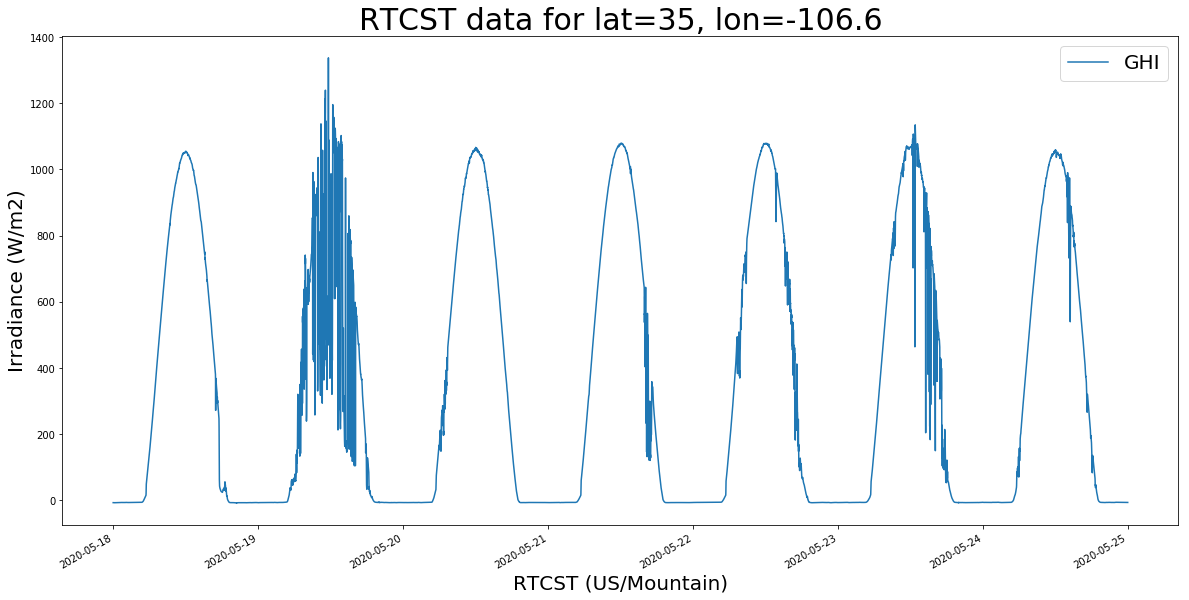

In [26]:
# Plot GHI
irrad_var = ['GHI']
weather_df[irrad_var].plot(figsize=(20,10));
plt.ylabel('Irradiance (W/m2)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

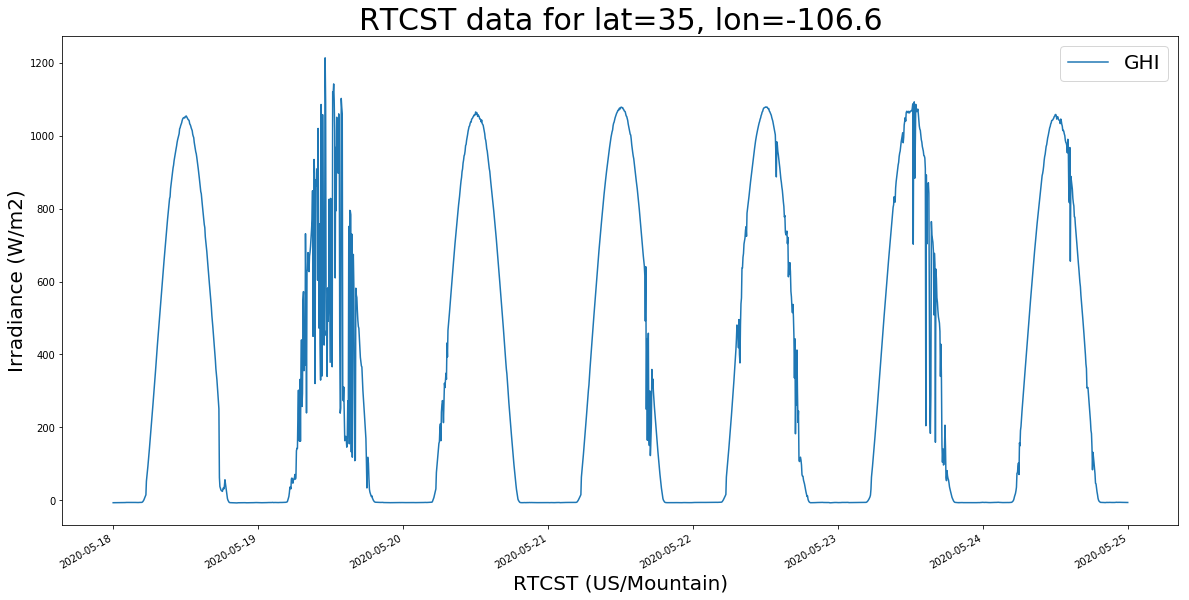

In [27]:
# Plot GHI
irrad_var = ['GHI']
weather_df_slice[irrad_var].plot(figsize=(20,10));
plt.ylabel('Irradiance (W/m2)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

## System PIV May 18 to May 25

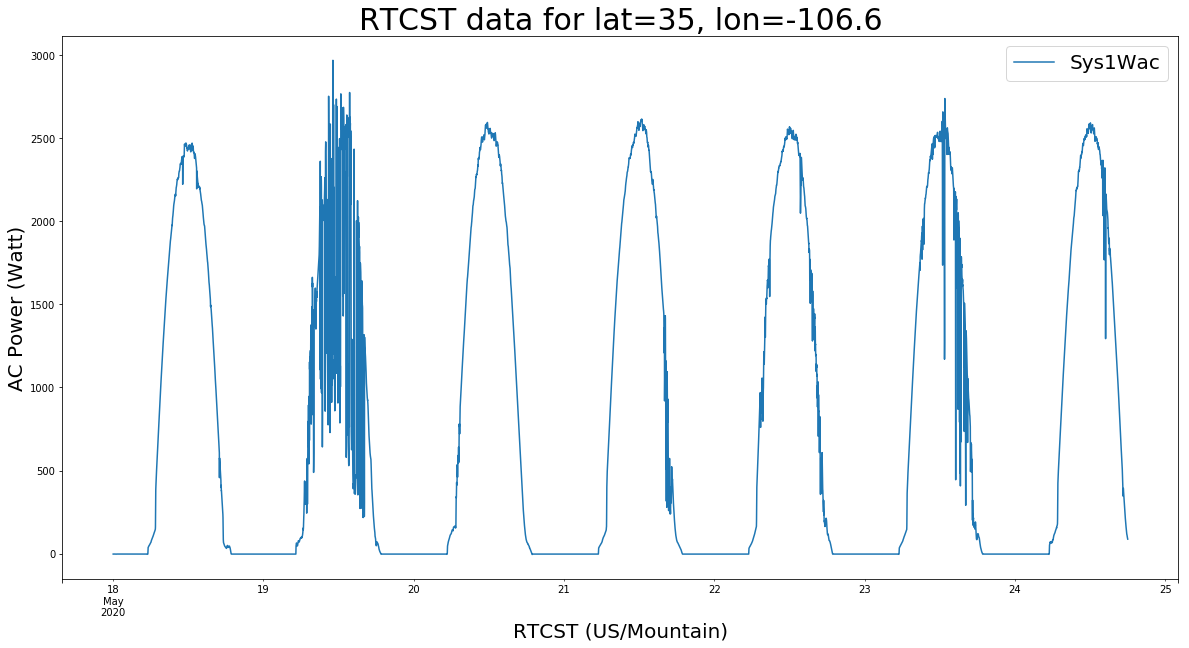

In [28]:
# Plot AC Power Output
sys1i_var = ['Sys1Wac']
system_df[sys1i_var].plot(figsize=(20,10));
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

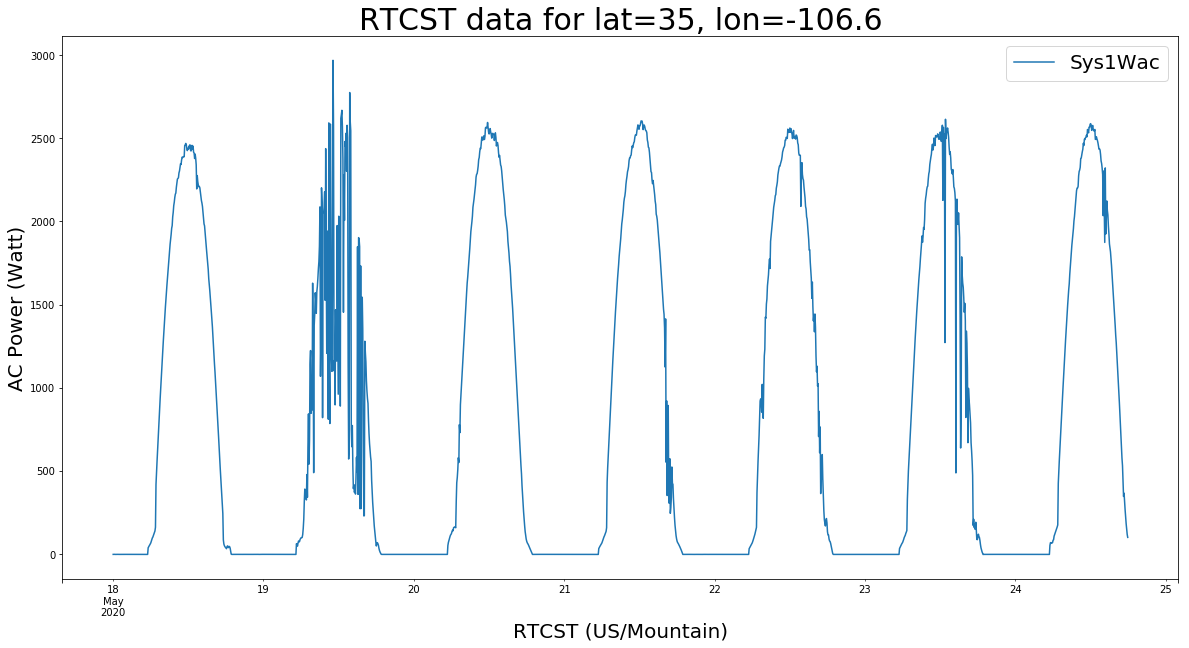

In [29]:
# Plot AC Power Output
sys1i_var = ['Sys1Wac']
system_df_slice[sys1i_var].plot(figsize=(20,10));
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

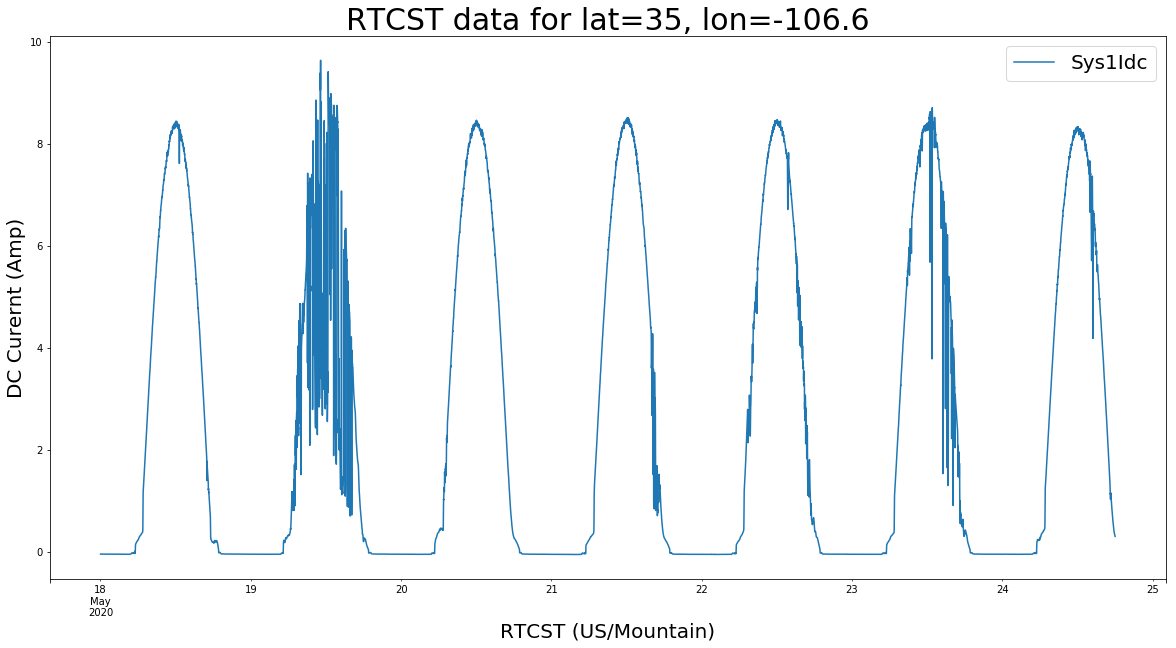

In [30]:
# Plot DC Current
sys1i_var = ['Sys1Idc']
system_df[sys1i_var].plot(figsize=(20,10));
plt.ylabel('DC Curernt (Amp)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

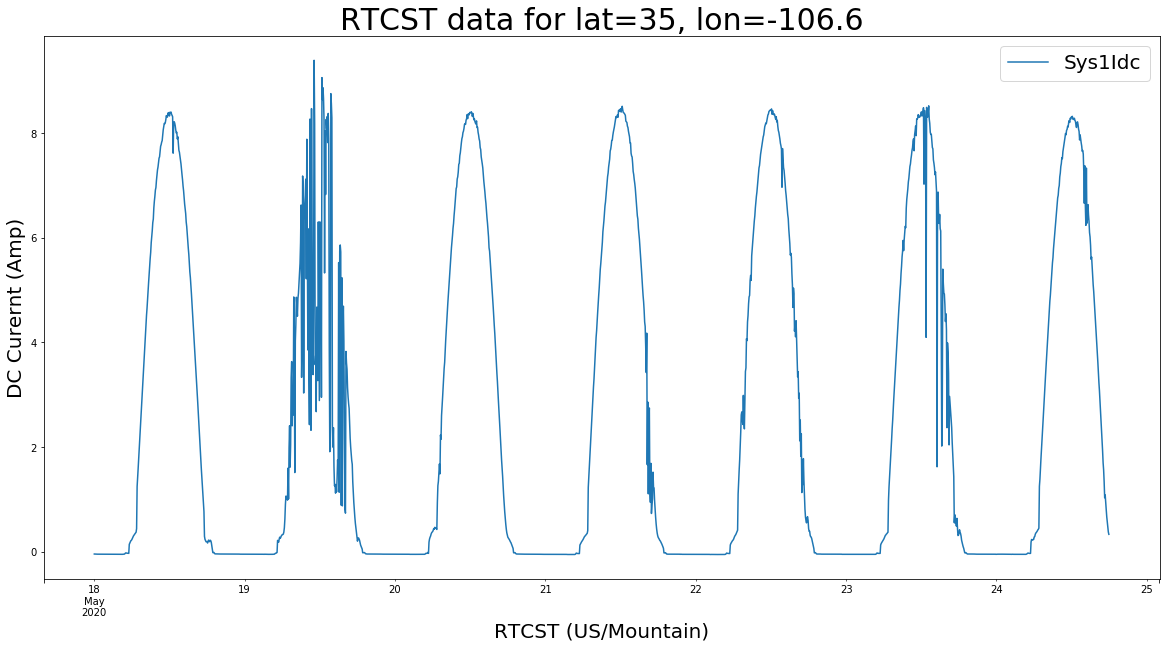

In [31]:
# Plot DC Current
sys1i_var = ['Sys1Idc']
system_df_slice[sys1i_var].plot(figsize=(20,10));
plt.ylabel('DC Curernt (Amp)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

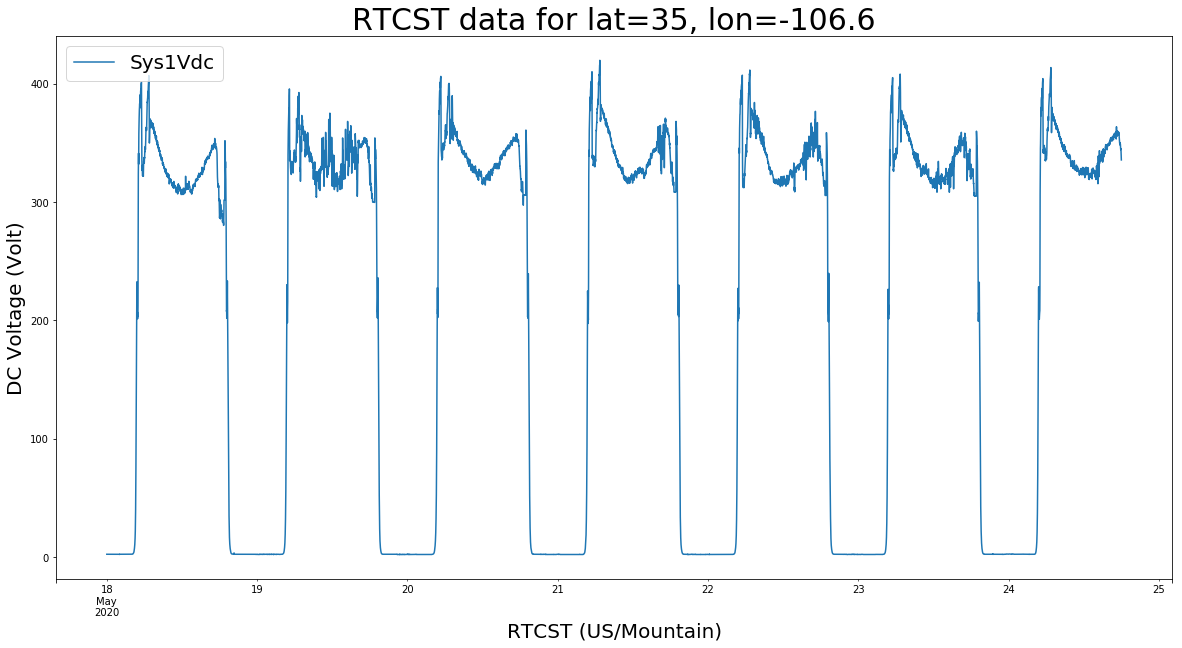

In [32]:
# Plot DC Voltage
sys1v_var = ['Sys1Vdc']
system_df[sys1v_var].plot(figsize=(20,10));
plt.ylabel('DC Voltage (Volt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

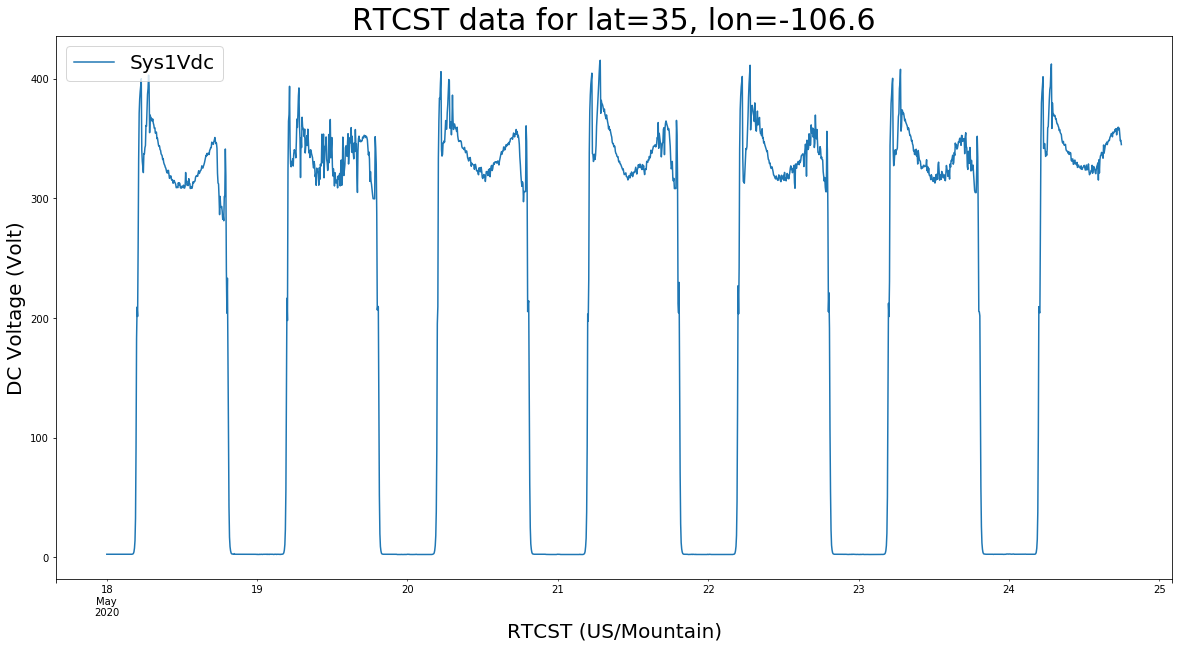

In [33]:
# Plot DC Voltage
sys1v_var = ['Sys1Vdc']
system_df_slice[sys1v_var].plot(figsize=(20,10));
plt.ylabel('DC Voltage (Volt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

In [34]:
# Read CSV
forecast_df_irrad = pd.read_csv('Working Irrad.csv')
print("Keys of forecast_df_irrad: \n{}".format(forecast_df_irrad.keys()))

Keys of forecast_df_irrad: 
Index(['Unnamed: 0', 'ghi', 'dni', 'dhi'], dtype='object')


In [35]:
forecast_df_irrad.describe()

,ghi,dni,dhi
count,1945.000000,1945.000000,1945.000000
mean,311.763243,273.839569,114.811720
std,351.271385,305.255717,130.324338
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,133.430596,74.863760,75.266829
75%,639.459985,611.249808,212.220653
max,973.680512,758.057143,488.252373


In [36]:
forecast_df_irrad.head()

,Unnamed: 0,ghi,dni,dhi
0,2020-05-18 06:00:00-06:00,0.000000,0.0,0.000000
1,2020-05-18 06:05:00-06:00,0.078719,0.0,0.078719
2,2020-05-18 06:10:00-06:00,0.572488,0.0,0.572488
3,2020-05-18 06:15:00-06:00,1.915673,0.0,1.915673
4,2020-05-18 06:20:00-06:00,4.421121,0.0,4.421121


In [37]:
# Read CSV
forecast_df_ac = pd.read_csv('Working AC.csv')
print("Keys of forecast_df_ac: \n{}".format(forecast_df_ac.keys()))

Keys of forecast_df_ac: 
Index(['2020-05-18 06:00:00-06:00', '0.0'], dtype='object')


In [38]:
forecast_df_ac.head()

,2020-05-18 06:00:00-06:00,0.0
0,2020-05-18 06:05:00-06:00,-1.560000
1,2020-05-18 06:10:00-06:00,-1.560000
2,2020-05-18 06:15:00-06:00,-1.560000
3,2020-05-18 06:20:00-06:00,-1.560000
4,2020-05-18 06:25:00-06:00,13.664137


In [39]:
# TimeStamp as Index
forecast_df_ac.set_index('2020-05-18 06:00:00-06:00', inplace=True)
forecast_df_ac.head()

,0.0
2020-05-18 06:00:00-06:00,
2020-05-18 06:05:00-06:00,-1.560000
2020-05-18 06:10:00-06:00,-1.560000
2020-05-18 06:15:00-06:00,-1.560000
2020-05-18 06:20:00-06:00,-1.560000
2020-05-18 06:25:00-06:00,13.664137


In [40]:
forecast_df_ac.describe()

,0.0
count,1944.000000
mean,1096.388502
std,1114.846827
min,-1.560000
25%,0.000000
50%,786.386870
75%,2290.298588
max,2869.122379


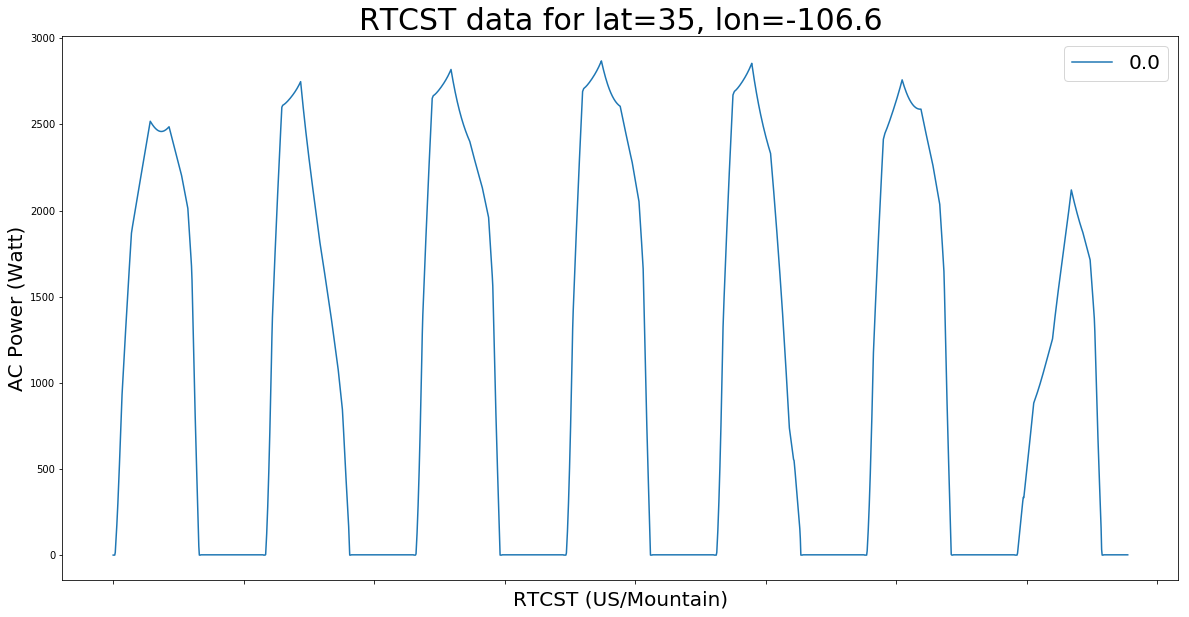

In [41]:
# Plot AC Power
forecast_ac = ['0.0']
forecast_df_ac[forecast_ac].plot(figsize=(20,10));
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

In [42]:
# Read CSV
forecast_df_dc = pd.read_csv('Working DC.csv')
print("Keys of forecast_df_dc: \n{}".format(forecast_df_dc.keys()))

Keys of forecast_df_dc: 
Index(['Unnamed: 0', 'i_sc', 'i_mp', 'v_oc', 'v_mp', 'p_mp', 'i_x', 'i_xx'], dtype='object')


In [43]:
forecast_df_dc.describe()

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
count,1945.000000,1945.000000,1945.000000,1945.000000,1945.000000,1945.000000,1945.000000
mean,1.999114,1.783443,475.258638,382.018586,1168.444840,1.952383,1.294171
std,2.006281,1.787011,399.855351,322.684400,1174.139440,1.960044,1.280845
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.507058,1.352193,767.087009,609.183067,884.434696,1.469271,1.047082
75%,4.247590,3.788807,830.637900,667.441073,2420.100924,4.149018,2.731157
max,4.931789,4.373182,861.374268,719.429787,3026.915313,4.819467,3.109709


In [44]:
forecast_df_dc.head()

,Unnamed: 0,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
0,2020-05-18 06:00:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-05-18 06:05:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-05-18 06:10:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2020-05-18 06:15:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2020-05-18 06:20:00-06:00,0.084841,0.076876,714.288814,488.273516,37.536332,0.082632,0.061241


## Error
### Mean Square Error

In [45]:
y_true= system_df_slice['Sys1Wac']
y_pred= forecast_df_ac['0.0']
print('Mean Square Error:\n',mean_squared_error(y_true, y_pred))

Mean Square Error:
 2002194.216287371


### Merge DataFrames

In [46]:
# Clear Index
forecast_df_ac=forecast_df_ac.reset_index()
system_df_slice=system_df_slice.reset_index()

In [47]:
forecast_df_ac.head()

,2020-05-18 06:00:00-06:00,0.0
0,2020-05-18 06:05:00-06:00,-1.560000
1,2020-05-18 06:10:00-06:00,-1.560000
2,2020-05-18 06:15:00-06:00,-1.560000
3,2020-05-18 06:20:00-06:00,-1.560000
4,2020-05-18 06:25:00-06:00,13.664137


In [48]:
system_df_slice.head()

,TimeStamp,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
0,2020-05-18 00:01:00,24.683332,-3.476246,0.0,0.0,-0.04200,2.400000,-2.569879,0.006,1.600000,0.0
1,2020-05-18 00:06:00,24.400000,-3.476246,0.0,0.0,-0.04275,2.400000,-2.275785,0.006,1.600000,0.0
2,2020-05-18 00:11:00,24.199999,-3.476246,0.0,0.0,-0.04275,2.400000,-2.276448,0.006,1.633333,0.0
3,2020-05-18 00:16:00,23.949999,-3.476246,0.0,0.0,-0.04250,2.400000,-2.570519,0.006,1.683333,0.0
4,2020-05-18 00:21:00,23.541666,-4.634994,0.0,0.0,-0.04350,2.416667,-2.716421,0.006,1.800000,0.0


In [49]:
# I guess it will make plotting easier
system=system_df_slice['Sys1Wac']
forecast_df_ac['System']=system
forecast_df_ac.head()

,2020-05-18 06:00:00-06:00,0.0,System
0,2020-05-18 06:05:00-06:00,-1.560000,-2.569879
1,2020-05-18 06:10:00-06:00,-1.560000,-2.275785
2,2020-05-18 06:15:00-06:00,-1.560000,-2.276448
3,2020-05-18 06:20:00-06:00,-1.560000,-2.570519
4,2020-05-18 06:25:00-06:00,13.664137,-2.716421


In [50]:
# TimeStamp as Index
forecast_df_ac.set_index('2020-05-18 06:00:00-06:00', inplace=True)
forecast_df_ac.head()

,0.0,System
2020-05-18 06:00:00-06:00,,
2020-05-18 06:05:00-06:00,-1.560000,-2.569879
2020-05-18 06:10:00-06:00,-1.560000,-2.275785
2020-05-18 06:15:00-06:00,-1.560000,-2.276448
2020-05-18 06:20:00-06:00,-1.560000,-2.570519
2020-05-18 06:25:00-06:00,13.664137,-2.716421


In [51]:
# Examine the column labels
all(isinstance(column, str) for column in forecast_df_ac.columns)

True

In [ ]:
plt.figure(figsize=(12,12))
plt.plot('0.0', data=forecast_df_ac, marker='', color='skyblue', linewidth=2);
plt.plot('System', data=forecast_df_ac, marker='', color='olive', linewidth=2);
plt.legend();

In [ ]:
x=
y=
y2=

plt.figure(figsize=(30,15))
plt.plot(x,y, label = "GHI")
plt.plot(x,y2, label = "DHI")
plt.ylabel('Irradiance (W/m2)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST Data lat={}, lon={}'.format(latitude, longitude),size=20);
plt.legend(prop={'size': 20});
plt.show()

In [53]:


x = np.arange(0, 10, 0.1)
ticks = np.arange(0, 10, 0.1)
y1 = np.zeros((len(x)))
y2 = np.zeros((len(x)))
xmax = 0.0
imax = 0
for ii in range(len(x)):
    y1[ii] = 50 * ii - 5 * ii**2
    y2[ii] = 50 * ii - 7 * ii**2
    ticks[ii] = y1[ii]-y2[ii]
    if (y1[ii] < 0.0):
        xmax = x[ii]
        imax = ii
        break
ymax = max(y1)
fig = plt.figure(figsize=(8,4), dpi=300)
plt.plot(x, y1, 'g:')
plt.plot(x, y2, 'b:')
plt.ylim([0, ymax*1.05])
plt.xlim([0, xmax])
plt.fill_between(x, y1, y2, color='grey', alpha='0.3')
print imax
for ii in range(imax):
    plt.text(x[ii], ymax*0.01, ticks[ii])
plt.show()

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(imax)? (<ipython-input-53-7a05db660b8f>, line 24)

In [ ]:
df = pd.DataFrame(d)

male = df['Male'].tolist()
female = df['Female'].tolist()
year = df['Year'].tolist()
ymax = max(male)
ymin = min(female)
fig = plt.figure(figsize=(16,10), dpi=300)

# ymin*0.99 should be changed according to the dataset
for ii in range(len(male)):
    plt.text(year[ii]-0.1, ymin*0.99, male[ii]-female[ii], size=16)

plt.plot(year, male, marker=".", color="#5bc0de")
plt.plot(year, female, marker=".", color="#E8743B")
plt.ylim([ymin*0.985, ymax*1.01])
plt.fill_between(year, male, female, color="grey", alpha="0.3")
plt.yticks(male, size=16)
plt.xticks(year, size=16)
plt.title("Matplotlib fill_between() and text() 
           from pandas.DataFrame example", fontsize=20)
plt.show()

In [ ]:
sns.set(font='Times New Roman')

syst_ac = forecast_df_ac['System'].tolist()
for_ac = forecast_df_ac['0.0'].tolist()
tframe = forecast_df_ac.index.values
ymax = max(syst_ac)
ymin = min(for_ac)
fig = plt.figure(figsize=(16,10), dpi=300)

# ymin*0.99 should be changed according to the dataset
for ii in range(len(syst_ac)):
    plt.text(tframe[ii]-0.1, ymin*0.99, syst_ac[ii]-for_ac[ii], size=16)

plt.plot(tframe, syst_ac, marker=".", color="#5bc0de")
plt.plot(tframe, for_ac, marker=".", color="#E8743B")
plt.ylim([ymin*0.985, ymax*1.01])
plt.fill_between(tframe, syst_ac, for_ac, color="grey", alpha="0.3")
plt.yticks(syst_ac, size=16)
plt.xticks(tframe, size=16)
plt.title("Matplotlib fill_between() and text() from pandas.DataFrame example", fontsize=20)
plt.show()

In [ ]:
sns.set(font='Times New Roman')

rtc_ac = system_df_slice['Sys1Wac'].tolist()
for_ac = forecast_df_ac['0.0'].tolist()
tframe = system_df_slice.index.values
ymax = max(rtc_ac)
ymin = min(for_ac)
fig = plt.figure(figsize=(16,10), dpi=300)

# ymin*0.99 should be changed according to the dataset
for ii in range(len(rtc_ac)):
    plt.text(tframe[ii]-0.1, ymin*0.99, rtc_ac[ii]-for_ac[ii], size=16)

plt.plot(tframe, rtc_ac, marker=".", color="#5bc0de")
plt.plot(tframe, for_ac, marker=".", color="#E8743B")
plt.ylim([ymin*0.985, ymax*1.01])
plt.fill_between(tframe, rtc_ac, for_ac, color="grey", alpha="0.3")
plt.yticks(rtc_ac, size=16)
plt.xticks(tframe, size=16)
plt.title("Matplotlib fill_between() and text() from pandas.DataFrame example", fontsize=20)
plt.show()

In [ ]:
x = np.arange(0, 10, 0.1)
ticks = np.arange(0, 10, 0.1)
y1 = np.zeros((len(x)))
y2 = np.zeros((len(x)))
xmax = 0.0
imax = 0
for ii in range(len(x)):
    y1[ii] = 50 * ii - 5 * ii**2
    y2[ii] = 50 * ii - 7 * ii**2
    ticks[ii] = y1[ii]-y2[ii]
    if (y1[ii] < 0.0):
        xmax = x[ii]
        imax = ii
        break
ymax = max(y1)
fig = plt.figure(figsize=(8,4), dpi=300)
plt.plot(x, y1, 'g:')
plt.plot(x, y2, 'b:')
plt.ylim([0, ymax*1.05])
plt.xlim([0, xmax])
plt.fill_between(x, y1, y2, color='grey', alpha='0.3')
print(imax)
for ii in range(imax):
    plt.text(x[ii], ymax*0.01, ticks[ii])
plt.show()